In [1]:
%matplotlib inline
import os
os.chdir('U:\\GitHubClones\\SALTSeniorDesign')
os.getcwd()
#import Excel
import xlwings as xw
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import re
from datetime import datetime
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
import time

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
wb = xw.Book('Salt.xlsm')
setup = wb.sheets('Setup')
output = wb.sheets('Output')
strats = wb.sheets('Strat Tables')
performance = wb.sheets('Performance')

# Path For the Current deal that is selected based on Setup
directory = setup['Setup.Directory'].value
shelf = setup['Setup.Shelf'].value
deal = setup['Setup.Deal'].value
report = setup['Setup.Report'].value
num_Deals = setup['Setup.Num_Deals'].value
max_Report = setup['Setup.Max_Report_Num'].value

In [18]:
tapes = np.array(setup['Tapes'].value)
tapes = tapes[0:int(max_Report),0:int(num_Deals)]
dfTapes = pd.DataFrame(data=tapes[1:,1:], columns=tapes[0,1:])
dfTapes

,AMCAR 2017-1,AMCAR 2017-2,AMCAR 2017-3,SDART 2017-1,SDART 2017-2,SDART 2017-3
0,2017\01 January\2017.03.23_AmeriCredit Automob...,2017\03 March\2017.05.02_AmeriCredit Automobil...,2017\06 June\2017.07.01_AmeriCredit Automobile...,2017\01 January\2017.02.15_Santander Drive Aut...,2017\04 April\2017.05.18_Santander Drive Auto ...,2017\08 August\2017.09.07_Santander Drive Auto...
1,2017\02 February\2017.03.23_AmeriCredit Automo...,2017\04 April\2017.06.23_AmeriCredit Automobil...,2017\07 July\2017.08.25_AmeriCredit Automobile...,2017\02 February\2017.03.15_Santander Drive Au...,2017\05 May\2017.06.15_Santander Drive Auto Re...,2017\09 September\2017.10.16_Santander Drive A...
2,2017\03 March\2017.04.24_AmeriCredit Automobil...,2017\05 May\2017.07.24_AmeriCredit Automobile ...,2017\08 August\2017.09.25_AmeriCredit Automobi...,2017\03 March\2017.04.17_Santander Drive Auto ...,2017\06 June\2017.07.17_Santander Drive Auto R...,None
3,2017\04 April\2017.05.23_AmeriCredit Automobil...,2017\06 June\2017.08.23_AmeriCredit Automobile...,None,2017\04 April\2017.05.15_Santander Drive Auto ...,2017\07 July\2017.08.15_Santander Drive Auto R...,None
4,2017\05 May\2017.06.23_AmeriCredit Automobile ...,2017\08 August\2017.09.25_AmeriCredit Automobi...,None,2017\05 May\2017.06.15_Santander Drive Auto Re...,2017\08 August\2017.09.15_Santander Drive Auto...,None
5,2017\06 June\2017.07.24_AmeriCredit Automobile...,None,None,2017\06 June\2017.07.17_Santander Drive Auto R...,2017\09 September\2017.10.16_Santander Drive A...,None
6,2017\07 July\2017.08.23_AmeriCredit Automobile...,None,None,2017\07 July\2017.08.15_Santander Drive Auto R...,None,None
7,2017\08 August\2017.09.25_AmeriCredit Automobi...,None,None,2017\08 August\2017.09.15_Santander Drive Auto...,None,None


In [19]:
umRatePath = 'U:\\GitHubClones\\SALTSeniorDesign\\' + 'State_level_unemployment_rate.csv'
umrate = pd.read_csv(umRatePath, memory_map=True, low_memory=False)
umrate

,Date,AK,AL,AR,AZ,CA,CO,CT,DC,DE,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,1/1/2017,6.5,6.4,3.8,5.0,5.2,2.9,4.5,5.7,4.4,...,2.9,5.4,4.8,3.1,4.0,3.1,5.1,3.9,5.6,4.8
1,2/1/2017,6.4,6.2,3.7,5.1,5.0,2.9,4.7,5.7,4.5,...,2.8,5.3,4.9,3.1,3.9,3.0,4.9,3.7,5.2,4.7
2,3/1/2017,6.4,5.8,3.6,5.0,4.9,2.6,4.8,5.8,4.5,...,2.8,5.1,5.0,3.1,3.8,3.0,4.7,3.4,4.9,4.5
3,4/1/2017,6.6,5.4,3.5,5.0,4.8,2.3,4.9,5.9,4.6,...,2.8,4.7,5.0,3.1,3.8,3.1,4.6,3.2,4.8,4.3
4,5/1/2017,6.7,4.9,3.4,5.1,4.7,2.3,4.9,6.0,4.7,...,2.9,4.0,4.8,3.2,3.8,3.2,4.5,3.1,4.5,4.1
5,6/1/2017,6.8,4.6,3.4,5.1,4.7,2.3,5.0,6.1,4.7,...,3.0,3.6,4.6,3.4,3.7,3.2,4.5,3.1,4.6,3.9
6,7/1/2017,7.0,4.5,3.4,5.1,4.8,2.4,5.0,6.4,4.8,...,3.1,3.4,4.3,3.5,3.8,3.1,4.5,3.2,4.7,4.0
7,8/1/2017,7.2,4.2,3.5,5.0,5.1,2.4,4.8,6.4,4.9,...,3.3,3.3,4.2,3.5,3.8,3.0,4.6,3.4,5.0,4.0
8,9/1/2017,7.2,3.8,3.5,4.7,5.1,2.5,4.6,6.5,4.9,...,3.4,3.0,4.0,3.4,3.7,2.9,4.6,3.5,5.1,4.0
9,10/1/2017,7.2,3.6,3.6,4.5,4.9,2.7,4.5,6.6,4.8,...,3.5,3.0,3.9,3.3,3.6,2.9,4.5,3.4,5.1,4.2


In [20]:
df['reportingPeriodBeginningDate'] = pd.to_datetime(df['reportingPeriodBeginningDate'])
umrate['Date'] = pd.to_datetime(umrate['Date']).strftime('%m/%d/%Y')
umrate = umrate.set_index('Date')


In [21]:
stateDict = umrate.to_dict(orient='index')

In [22]:
cols = ['assetNumber', 'reportingPeriodEndingDate','reportingPeriodBeginningDate',
        'originalLoanTerm','originalLoanAmount','vehicleValueAmount','originalInterestRatePercentage','subvented',
        'vehicleNewUsedCode', 'vehicleModelYear','vehicleTypeCode',
        'obligorCreditScore','obligorIncomeVerificationLevelCode', 'obligorEmploymentVerificationCode','obligorGeographicLocation',
        'paymentToIncomePercentage', 'reportingPeriodActualEndBalanceAmount',
        'reportingPeriodBeginningLoanBalanceAmount','totalActualAmountPaid',
        'remainingTermToMaturityNumber',
        'currentDelinquencyStatus','coObligorIndicator',
        'zeroBalanceCode']

remove = ['assetNumber', 'reportingPeriodEndingDate','originalLoanAmount','vehicleValueAmount','reportingPeriodActualEndBalanceAmount',
        'reportingPeriodBeginningLoanBalanceAmount','totalActualAmountPaid','subvented','vehicleNewUsedCode','zeroBalanceCode',
        'vehicleModelYear','obligorIncomeVerificationLevelCode', 'obligorEmploymentVerificationCode','currentDelinquencyStatus']

train = pd.DataFrame()
for i in range(0, len(dfTapes[deal].index)):
    path = directory + '\\' + shelf + '\\' + deal + '\\' + dfTapes[deal][i]
    df = pd.read_csv(path, usecols=cols, memory_map=True, low_memory=False)
    df = df[~df.zeroBalanceCode.isin(['-'])] #taking out all of the performing loans so far
    df['LTV'] = (df['originalLoanAmount']/df['vehicleValueAmount'])*100
    df['loanDiff'] = (df['originalLoanAmount'] - df['reportingPeriodBeginningLoanBalanceAmount'])
    df['coObligorIndicator'] = df['coObligorIndicator'].astype(int)
    df['verifyScore'] = df['obligorIncomeVerificationLevelCode'] + df['obligorEmploymentVerificationCode']
    states = list(df['obligorGeographicLocation'])
    uniqueList = df.reportingPeriodBeginningDate.unique()
    umList = []
    for i in range(0, len(states)):
        val = stateDict[uniqueList[i]].get(states[j])
        umList.append(val)
    train['StateUnemployment'] = umList
    train = train.append(df)

train['obligorCreditScore'] = train['obligorCreditScore'].replace(['-'], 0)

train['subvented'] = pd.to_numeric(train['subvented'], errors = 'coerce').fillna(5)
train['zeroBalanceCode'] = pd.to_numeric(train['zeroBalanceCode'], errors = 'coerce')
train['obligorCreditScore'] = pd.to_numeric(train['obligorCreditScore'], errors = 'coerce')

KeyError: '02-01-2017'

In [7]:
# 1 is true and 0 is false

'''
train['LTV100'] = np.where((train['LTV']>=0) & (train['LTV']<=100), 1, 0)
train['LTV110'] = np.where((train['LTV']>100) & (train['LTV']<=110), 1, 0)
train['LTV120'] = np.where((train['LTV']>110) & (train['LTV']<=120), 1, 0)
train['LTV120+'] = np.where((train['LTV']>120), 1, 0)


train['originalTerm'] = np.where((train['originalLoanTerm']>=0) & (train['LTV']<=60), 1, 0)# 1 means =< 60, 0 means > 70 
'''


'''
train['ModelYear'] = np.where((train['vehicleModelYear']> 2012), 1, 0) #model years that are less than 5 years old = 1, older than 5 years 0
train['PTI'] = np.where((train['paymentToIncomePercentage']> .1), 1, 0) # PTI > 10% is a 1, less than 10% is a 0

train['interestRate15'] = np.where((train['originalInterestRatePercentage']>=0) & (train['originalInterestRatePercentage']<=15), 1, 0)
train['interestRate20'] = np.where((train['originalInterestRatePercentage']>15) & (train['originalInterestRatePercentage']<=20), 1, 0)
train['interestRate25'] = np.where((train['originalInterestRatePercentage']>20) & (train['originalInterestRatePercentage']<=25), 1, 0)
train['interestRate25+'] = np.where((train['originalInterestRatePercentage']>25), 1, 0)

train['remainingTerm24'] = np.where((train['remainingTermToMaturityNumber']>=0) & (train['remainingTermToMaturityNumber']<=24), 1, 0)
train['remainingTerm48'] = np.where((train['remainingTermToMaturityNumber']> 24) & (train['remainingTermToMaturityNumber']<=48), 1, 0)
train['remainingTerm72'] = np.where((train['remainingTermToMaturityNumber']> 48) & (train['remainingTermToMaturityNumber']<=72), 1, 0)
train['remainingTerm72+'] = np.where((train['remainingTermToMaturityNumber']> 72), 1, 0)

train['dqStatus30'] = np.where((train['currentDelinquencyStatus']>=0) & (train['currentDelinquencyStatus']<=30), 1, 0)
train['dqStatus60'] = np.where((train['currentDelinquencyStatus']>30) & (train['currentDelinquencyStatus']<=60), 1, 0)
train['dqStatus90'] = np.where((train['currentDelinquencyStatus']>60) & (train['currentDelinquencyStatus']<=90), 1, 0)
train['dqStatus90+'] = np.where((train['currentDelinquencyStatus']>90), 1, 0)

train['employeeNotStatedNotVerified'] = np.where((train['obligorEmploymentVerificationCode']==1), 1, 0)
train['employeeStatedNotVerified'] = np.where((train['obligorEmploymentVerificationCode']==2), 1, 0)
train['employeeStatedVerified'] = np.where((train['obligorEmploymentVerificationCode']==3), 1, 0)

train['incomeNotVerifed'] = np.where((train['obligorIncomeVerificationLevelCode']>=1) & (train['obligorIncomeVerificationLevelCode']<=2), 1, 0)
train['incomeVerifed'] = np.where((train['obligorIncomeVerificationLevelCode'] == 3), 1, 0)
train['incomeVerifed12'] = np.where((train['obligorIncomeVerificationLevelCode'] == 4), 1, 0)
train['incomeVerifed24'] = np.where((train['obligorIncomeVerificationLevelCode'] == 5), 1, 0)

'''


"\ntrain['ModelYear'] = np.where((train['vehicleModelYear']> 2012), 1, 0) #model years that are less than 5 years old = 1, older than 5 years 0\ntrain['PTI'] = np.where((train['paymentToIncomePercentage']> .1), 1, 0) # PTI > 10% is a 1, less than 10% is a 0\n\ntrain['interestRate15'] = np.where((train['originalInterestRatePercentage']>=0) & (train['originalInterestRatePercentage']<=15), 1, 0)\ntrain['interestRate20'] = np.where((train['originalInterestRatePercentage']>15) & (train['originalInterestRatePercentage']<=20), 1, 0)\ntrain['interestRate25'] = np.where((train['originalInterestRatePercentage']>20) & (train['originalInterestRatePercentage']<=25), 1, 0)\ntrain['interestRate25+'] = np.where((train['originalInterestRatePercentage']>25), 1, 0)\n\ntrain['remainingTerm24'] = np.where((train['remainingTermToMaturityNumber']>=0) & (train['remainingTermToMaturityNumber']<=24), 1, 0)\ntrain['remainingTerm48'] = np.where((train['remainingTermToMaturityNumber']> 24) & (train['remainingTermT

In [114]:
train['newUsed'] = np.where((train['vehicleNewUsedCode']>1), 1, 0) # 0 means new, 1 means used
train['subvent'] = np.where((train['subvented']>0), 1, 0) # 0 means no subvention, 1 means subvent
#train['incomeVerifed'] = np.where((train['obligorIncomeVerificationLevelCode']>= 3) & (train['obligorIncomeVerificationLevelCode']<= 5), 1, 0)

#train['employeeVerified'] = np.where((train['obligorEmploymentVerificationCode']==3), 1, 0)

'''
train['noScore'] = np.where((train['obligorCreditScore'] == '-'), 1, 0)

train['obligorCreditScore'] = pd.to_numeric(train['obligorCreditScore'], errors='coerce').fillna(0)

train['ficoScore550'] = np.where((train['obligorCreditScore']> 0) & (train['obligorCreditScore']<=550), 1, 0)
train['ficoScore650'] = np.where((train['obligorCreditScore']>550) & (train['obligorCreditScore']<=650), 1, 0)
train['ficoScore750'] = np.where((train['obligorCreditScore']>650) & (train['obligorCreditScore']<=750), 1, 0)
train['ficoScore750+'] = np.where((train['obligorCreditScore']>750), 1, 0)'''


train['Default'] = np.where((train['zeroBalanceCode'] == 4), 1, 0)

train = train.drop(remove, axis=1)

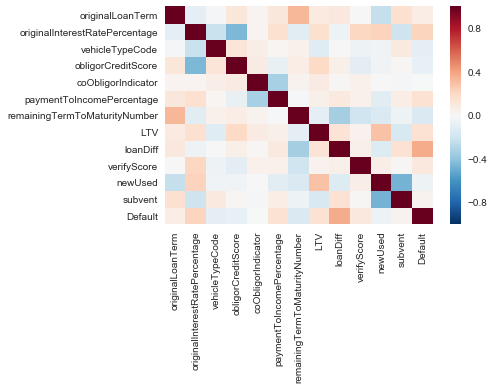

In [115]:
sb.heatmap(train.corr())

In [116]:
x = list(train.columns)
x = x[:-1]
x = train[x]
y = train.Default


In [108]:
est = sm.OLS(y, train[x]).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Default   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     798.4
Date:                Thu, 16 Nov 2017   Prob (F-statistic):               0.00
Time:                        18:41:44   Log-Likelihood:                -5717.3
No. Observations:               10104   AIC:                         1.146e+04
Df Residuals:                   10092   BIC:                         1.155e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
originalLoanTerm                  -0.0027      0.001     -4.947      0.000      -0.004      -0.002
originalInterestRatePercentage     1.9227      0.111     17.333      0.000       1.705       2.140
vehicleTypeCode                   -0.0372      0.005     -7.207      0.000      -0.047      -0.027
obligorCreditScore             -6.245e-05   2.08e-05     -3.004      0.003      -0.000   -2.17e-05
coObligorIndicator                 0.0067      0.010      0.669      0.503      -0.013       0.027
paymentToIncomePercentage          0.7620      0.115      6.600      0.000       0.536       0.988
remainingTermToMaturityNumber     -0.0002      0.000     -0.616      0.538      -0.001       0.000
LTV                                0.0014      0.000      5.667      0.000       0.001       0.002
loanDiff                        1.838e-05   5.24e-07     35.075      0.000    1.74e-05    1.94e-05
verifyScore                       -0.0031      0.006     -0.519      0.604      -0.015       0.009
newUsed                           -0.0856      0.012     -7.414      0.000      -0.108      -0.063
subvent                           -0.0059      0.018     -0.330      0.741      -0.041       0.029
==============================================================================
Omnibus:                     2296.456   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              823.573
Skew:                           0.507   Prob(JB):                    1.46e-179
Kurtosis:                       2.036   Cond. No.                     3.50e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [117]:
logReg = sm.Logit(y,x).fit()
logReg.summary()

Optimization terminated successfully.
         Current function value: 0.550314
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                10104
Model:                          Logit   Df Residuals:                    10092
Method:                           MLE   Df Model:                           11
Date:                Thu, 16 Nov 2017   Pseudo R-squ.:                  0.1532
Time:                        18:56:53   Log-Likelihood:                -5560.4
converged:                       True   LL-Null:                       -6566.0
                                        LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
originalLoanTerm                  -0.0334      0.003    -11.529      0.000      -0.039      -0.028
originalInterestRatePercentage     9.1541      0.620     14.754      0.000       7.938      10.370
vehicleTypeCode                   -0.2799      0.029     -9.534      0.000      -0.337      -0.222
obligorCreditScore                -0.0004      0.000     -4.078      0.000      -0.001      -0.000
coObligorIndicator                 0.0565      0.055      1.020      0.308      -0.052       0.165
paymentToIncomePercentage          4.1199      0.631      6.527      0.000       2.883       5.357
remainingTermToMaturityNumber     -0.0025      0.001     -1.844      0.065      -0.005       0.000
LTV                                0.0060      0.001      4.384      0.000       0.003       0.009
loanDiff                        8.995e-05   2.98e-06     30.206      0.000    8.41e-05    9.58e-05
verifyScore                       -0.1401      0.032     -4.381      0.000      -0.203      -0.077
newUsed                           -0.5643      0.064     -8.845      0.000      -0.689      -0.439
subvent                           -0.0904      0.099     -0.917      0.359      -0.284       0.103
==================================================================================================
"""

In [111]:
LogReg = LogisticRegression()
LogReg.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
bins = {
    'LTV':[0,100, 110, 120],
    'originalLoanTerm':[0,70],
    'originalInterestRatePercentage':[0,15,20,25],
    'subvented':[0],#have to do != here
    'vehicleNewUsedCode':[0,1,2],
    'vehicleModelYear':[2012],
    'obligorCreditScore':[550,650,750],
    'obligorIncomeVerificationLevelCode':[3,5],
    'obligorEmploymentVerificationCode':[3],
    'paymentToIncomePercentage':[.1],
    'remainingTermToMaturityNumber':[24,48,72],
    'totalActualAmountPaid':[0]
}
train['obligorEmploymentVerificationCode'].unique()